**Skip to Content**
  __
 SAP Community Log-in Update
 In a few months, SAP Community will switch to SAP Universal ID as the only option to login. Don’t wait, create your SAP Universal ID
 now\! If you have multiple S- or P- accounts, use the Consolidation Tool to merge your content.
 Get started with SAP Universal ID
  __
   - Home
   - Community
   - Ask a Question
   - Write a Blog Post
   - Login / Sign-up
   -
 ###### Technical Articles
 Andreas Forster
 __
 July 27, 2020 21 minute read
 # Hands-On Tutorial: Automated Predictive \(APL\) in SAP HANA Cloud
 __14 __37 __7,162
 SAP HANA Cloud now includes the Automated Predictive Library \(APL\). Find out how to train ML models within SAP HANA Cloud
 automatically, without having to extract the data. Use the familiar SAP HANA Python Client API for ML to trigger the required
 calculations in the SAP HANA Cloud straight from your preferred Python environment. Most of the code is also relevant for SAP HANA
 on-premise.
 If you are in a hurry, you can read through this blog to become familiar with this concept. If you want to dig deep, you can follow
 the implementation steps and learn hands-on.
 This blog was written by both Marc Daniau \(Product Expert, SAP\) and Andreas FORSTER \(Global Center of Excellence, SAP\).
 Therefore, the term "we" in this blog refers to ourselves, Marc and Andreas, and not necessarily SAP. There is no guarantee or
 support for any information or code in this blog. Please test any content that you may want to use yourself.
 Our thanks go to Frank Gottfried, Christoph Morgen and Raymond Yao for their help in putting this tutorial together\!
 # Table of contents
   - Introduction / Use case
   - Setup SAP HANA Cloud
   - Setup local Python
   - Create SAP HANA user
   - Data upload
   - Data exploration
   - Train ML model
   - Apply ML model
   - Deployment
   - Summary
 # Introduction / Use case
 SAP HANA Cloud is the latest evolution of SAP HANA. Released in March 2020, it combines the technology known from the on-premise
 version of SAP HANA with cloud benefits such as scalability.
 It contains many of the known SAP HANA engines, such as the Automated Predictive Library \(APL\). The APL, which is a highly
 automated ML framework, has also been evolving and now includes a "Gradient Boosting Classification". This new Gradient Boosting
 Classification automates the process of finding an ML model, similar to the previous APL. The new Gradient Classification approach
 however tends to result in stronger models. Since the APL product group is focussing further improving this approach, we suggest
 working with the new "Gradient Boosting Classification", as we do in this blog.
 The APL can be called through SQL or directly from Python. In this blog we make use of Python and the corresponding library
 hana\_ml, which simplifies the calling of SAP HANA functionality. We will call the APL, but the library can also call the Predictive
 Algorithm Library \(PAL\).
 As example to work with the Gradient Boosting Classification, we will predict the affinity of a Banking customer to sign up for a
 term deposit, in which money can be locked for a certain period and accrues higher interest rates.
 # Setup SAP HANA Cloud
 To implement this Bank Marketing scenario you need access to SAP HANA Cloud. This SAP HANA Cloud with the following configuration:
   - It must have at least 3 virtual CPUs \(vCPUs\). The current SAP HANA Cloud Trial comes only with 2 vCPUs. In that trial it is not possible to increase the number of vCPUs. Therefore you must create your own instance of SAP HANA Cloud in the SAP Cloud Platform Cockpit as described in this playlist from the SAP HANA Academy, which also contains plenty of additional material.
   - Your SAP HANA Cloud must have the Script Server enabled to be able to use the Automated Predictive Library \(APL\). For a new SAP HANA Cloud instance the Script Server can be enabled when creating the instance. For existing sytems, the Script Server can be activated with a Service Request.
   - Your SAP HANA Cloud must permit connections from your IP address, e.g. by selecting "Allow all IP addresses".
 The "Getting Started with SAP HANA Cloud" guide also gives an excellent overview, just bear in mind that you cannot use the trial
 environment to implement this blog's hands-on scenario. Denys van Kempen has also put together a huge collection of SAP HANA Cloud
 material. In case you might be a little puzzled about the different version of SAP HANA that have been around, Denys has also
 created a SAP \(HANA\) Cheat Sheet.
 There is also a Learning Article on Using Jupyter Notebooks with SAP HANA Cloud that helps with the first steps.
 To continue hands-on, you need to know:
   - The SAP HANA Cloud endpoint \(e.g. xyz.hanacloud.ondemand.com\)
   - The HTTPS port, which is always 443
   - The password for the DBADMIN user
 # Setup local Python
 You need an environment to execute Python code. In case you already have an environment to work with, please use it. In case you are
 new to Python, we suggest installing Anaconda, which will install and configure everything that is needed.
 Once you have downloaded and installed Anaconda, open the Anaconda Navigator and select JupyterLab.
 An alternative, and much faster, approach to open JupyterLab is through the Anaconda Prompt. Open the Anaconda Prompt, then type:
 jupyter lab
 If you haven't worked with JupyterLab so far, not to worry It's easy to find your way around. One very useful introduction for the
 first steps is this tutorial from the California Institute of Technology \(Caltech\).
 With Python at your fingertips, create a new Python 3 Notebook and install SAP's hana\_ml library, which provides the connectivity
 and push-down to the SAP HANA Cloud.

In [60]:
!pip install hana_ml

After installation, check on the version that has been installed.

In [61]:
import hana_ml
print(hana_ml.__version__)

2.17.23062800


You should have at least version 2.5.20062605 for connecting to SAP HANA Cloud. This tutorial was tested with version 2.5.20062609.
 # Create SAP HANA user
 Test the connectivity by running a very simple SELECT statement. You will need the SAP HANA Cloud endpoint, HDB port and the DBADMIN
 user's password. Here we see the password in clear text only for a quick test. Later on, we will securely store the passwords.

In [62]:
import hana_ml.dataframe as dataframe
# Instantiate connection object
conn = dataframe.ConnectionContext(userkey='MYHANACLOUD')
# Send basic SELECT statement and display the result
sql = 'SELECT 12345 FROM DUMMY'
df_remote = conn.sql(sql)
print(df_remote.collect())

   12345
0  12345


If everything works as expected, the code should return the value 12345. Later on you will see how to keep the password secure. For
 now we continue with the connection to create a user on the SAP HANA Cloud to call the Automated Predictive Library.
 Create a user called ML, just change the password.

In [63]:
# cursor = conn.connection.cursor()
# cursor.execute('CREATE USER ML Password "YOURPASSWORD" SET USERGROUP DEFAULT;')

Keep things simple by specifying that the user does not have to change the password. Note that this is recommended only for
 technical users.

In [64]:
# cursor.execute('ALTER USER ML DISABLE PASSWORD LIFETIME;')

Grant the new ML user the right to call the Automated Predictive Library.

In [65]:
# ursor.execute('GRANT "sap.pa.apl.base.roles::APL_EXECUTE" TO ML')

Grant the ML user the right to call the Predictive Algorithm Library. This right is needed in this tutorial only so that the Boxplot
 that you will see later can be calculated in SAP HANA.

In [66]:
# cursor.execute('GRANT "AFL__SYS_AFL_AFLPAL_EXECUTE_WITH_GRANT_OPTION" TO ML')

Close the connection that was established with the DBADMIN user. From now on, we will use only the ML user.

In [67]:
# cursor.close()

However, we don't want to have the password visible in clear text. Use the Secure User Store from the SAP HANA client to securely
 store the logon credentials.
 Navigate in a command prompt \(cmd.exe\) to the folder that contains the hdbuserstore, e.g.
 C:\Program Files\SAP\hdbclient
 Then store the logon parameters in the Secure User Store, by calling the hdbuserstore application. In the example below the
 parameters are saved under a key called MYHANACLOUD. You are free to chose your own name.
 C:\Program Files\SAP\hdbclient>hdbuserstore -i SET MYHANACLOUD “YOURENDPOINT:PORT” ML
 The password is not specified in the above command as you will be prompted for it. Just note that the logon credentials have not
 been tested yet. They have only been saved.
 Use the stored credentials to logon without having to show the password.

In [68]:
import hana_ml.dataframe as dataframe
# Instantiate connection object
conn = dataframe.ConnectionContext(userkey = 'MYHANACLOUD')
# Send basic SELECT statement and display the result
sql = 'SELECT 12345 FROM DUMMY'
df_remote = conn.sql(sql)
print(df_remote.collect())
# Close connection
conn.close()

   12345
0  12345


The result of the SELECT statement has not changed of course. Now you are good to keep working with the ML user.
 # Data upload
 Your system is ready. Now you need to fill it with data to work with. We will be working with the "Bank Marketing Data Set" as
 shared by the UC Irvine Machine Learning Repository. Download bank.zip and extract the file bank-full.csv.
 Place the bank-full.csv into your JupyterLab environment, for example by uploading it through the File Browser.
 Create another Python 3 Notebook and rename it to "10 data upload". Begin with loading the CSV file into a Pandas DataFrame.

In [69]:
import pandas as pd
df_data = pd.read_csv('bank-full.csv', sep = ';')
df_data.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Before uploading the data to SAP HANA Cloud, carry out a few transformations. Turn the column headers into upper case.

In [70]:
df_data.columns = map(str.upper, df_data.columns)

Drop the DURATION column. It tells how many minutes the calls lasted when the term deposit was promoted. This column cannot be used
 as predictor to score a person's interest in signing up for the product. Before we call the person, we don't know the length of the
 phone call. Hence remove it from the DataFrame.

In [71]:
df_data = df_data.drop(['DURATION'],
                       axis = 1)

The target column is currently called just 'Y'. Rename it to something more self-explanatory.

In [72]:
df_data = df_data.rename(index = str, columns = {'Y': 'PURCHASE'})

Add an ID column.

In [73]:
df_data.insert(0, 'CUSTOMER_ID', df_data.reset_index().index)

Preview a few rows of the transformed data.

In [74]:
df_data.head(5)

,CUSTOMER_ID,AGE,JOB,MARITAL,EDUCATION,DEFAULT,BALANCE,HOUSING,LOAN,CONTACT,DAY,MONTH,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,PURCHASE
0,0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


We are happy with the data, so upload it to SAP HANA Cloud. Establish a connection with the hana\_ml wrapper…

In [75]:
import hana_ml.dataframe as dataframe
conn = dataframe.ConnectionContext(userkey = 'MYHANACLOUD')

… and upload the Pandas DataFrame into a table called BANKMARKETING.

In [76]:
df_remote = dataframe.create_dataframe_from_pandas(connection_context = conn,
                                                   pandas_df = df_data,
                                                   table_name = 'BANKMARKETING',
                                                   force = True,
                                                   replace = False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


Once we have trained a Machine Learning model, we want to apply it on new data. Therefore create a second table, in which you load
 two rows of "invented" customers, whose behaviour will be predicted.
 Create a new DataFrame, just without the target column.

In [77]:
df_topredict = pd.DataFrame(data = None,
                            columns = df_data.columns.drop('PURCHASE'))
for xx in df_topredict.columns:
    df_topredict[xx] = df_topredict[xx].astype(df_data[xx].dtypes.name)

Add the two imaginary customers.

In [78]:
df_topredict = pd.concat([df_topredict, pd.DataFrame({'CUSTOMER_ID': 1,
                                    'AGE': 40,
                                    'JOB': 'entrepreneur',
                                    'MARITAL': 'married',
                                    'EDUCATION': 'secondary',
                                    'DEFAULT': 'no',
                                    'BALANCE': 3000,
                                    'HOUSING': 'yes',
                                    'LOAN': 'no',
                                    'CONTACT': 'unknown',
                                    'DAY': 10,
                                    'MONTH': 'may',
                                    'CAMPAIGN': 1,
                                    'PDAYS': -1,
                                    'PREVIOUS': 0,
                                    'POUTCOME': 'unknown'}, index=[0])])
df_topredict = pd.concat([df_topredict, pd.DataFrame({'CUSTOMER_ID': 2,
                                    'AGE': 65,
                                    'JOB': 'management',
                                    'MARITAL': 'single',
                                    'EDUCATION': 'tertiary',
                                    'DEFAULT': 'no',
                                    'BALANCE': 3000,
                                    'HOUSING': 'no',
                                    'LOAN': 'no',
                                    'CONTACT': 'telephone',
                                    'DAY': 10,
                                    'MONTH': 'mar',
                                    'CAMPAIGN': 1,
                                    'PDAYS': -1,
                                    'PREVIOUS': 12,
                                    'POUTCOME': 'success'}, index=[0])])

Upload the new Pandas DataFrame into a table called BANKMARKETING\_TOPREDICT.

In [79]:
df_remote = dataframe.create_dataframe_from_pandas(connection_context = conn,
                                                   pandas_df = df_topredict,
                                                   table_name = 'BANKMARKETING_TOPREDICT',
                                                   force = True,
                                                   replace = False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 21.42it/s]


# Data exploration
 Now the real fun can start. Begin the Data Science part by exploring the data that we have to work with. Create a new Python 3
 Notebook called "20 Data exploration".
 Connect to SAP HANA Cloud.

In [80]:
import hana_ml.dataframe as dataframe
conn = dataframe.ConnectionContext(userkey = 'MYHANACLOUD')

Create a SAP HANA dataframe and point it to the table with the uploaded data. Sort the dataframe to ensure reproducibility.

In [81]:
df_remote = conn.table(table = 'BANKMARKETING', schema = 'ML_USER').sort('CUSTOMER_ID', desc = False)
df_remote.head(5).collect()

,CUSTOMER_ID,AGE,JOB,MARITAL,EDUCATION,DEFAULT,BALANCE,HOUSING,LOAN,CONTACT,DAY,MONTH,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,PURCHASE
0,0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


Alternatively, you can also base the SAP HANA dataframe on a SELECT statement.

In [82]:
df_remote = conn.sql('SELECT * FROM "ML_USER"."BANKMARKETING" ORDER BY "CUSTOMER_ID" ASC')
df_remote.head(5).collect()

,CUSTOMER_ID,AGE,JOB,MARITAL,EDUCATION,DEFAULT,BALANCE,HOUSING,LOAN,CONTACT,DAY,MONTH,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,PURCHASE
0,0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


Start exploring with the basics. How many rows are in the source?

In [83]:
df_remote.count()

45211

45211\. This value was calculated by SAP HANA. Only the final outcome was transferred back to Python.
 What are the names and types of the data columns?

In [84]:
df_remote.dtypes()

[('CUSTOMER_ID', 'INT', 10, 10, 10, 0),
 ('AGE', 'INT', 10, 10, 10, 0),
 ('JOB', 'VARCHAR', 5000, 5000, 5000, 0),
 ('MARITAL', 'VARCHAR', 5000, 5000, 5000, 0),
 ('EDUCATION', 'VARCHAR', 5000, 5000, 5000, 0),
 ('DEFAULT', 'VARCHAR', 5000, 5000, 5000, 0),
 ('BALANCE', 'INT', 10, 10, 10, 0),
 ('HOUSING', 'VARCHAR', 5000, 5000, 5000, 0),
 ('LOAN', 'VARCHAR', 5000, 5000, 5000, 0),
 ('CONTACT', 'VARCHAR', 5000, 5000, 5000, 0),
 ('DAY', 'INT', 10, 10, 10, 0),
 ('MONTH', 'VARCHAR', 5000, 5000, 5000, 0),
 ('CAMPAIGN', 'INT', 10, 10, 10, 0),
 ('PDAYS', 'INT', 10, 10, 10, 0),
 ('PREVIOUS', 'INT', 10, 10, 10, 0),
 ('POUTCOME', 'VARCHAR', 5000, 5000, 5000, 0),
 ('PURCHASE', 'VARCHAR', 5000, 5000, 5000, 0)]

Each column is listed with its name, type and size. The last two values are relevant when the data type is DECIMAL or SPATIAL.
 Now get some detailed column statistics, similar to how Pandas describes a DataFrame.

In [85]:
df_remote.describe().collect()

,column,count,unique,nulls,mean,std,min,max,median,25_percent_cont,25_percent_disc,50_percent_cont,50_percent_disc,75_percent_cont,75_percent_disc
0,CUSTOMER_ID,45211,45211,0,22605.000000,13051.435847,0.0,45210.0,22605.0,11302.5,11302.0,22605.0,22605.0,33907.5,33908.0
1,AGE,45211,77,0,40.936210,10.618762,18.0,95.0,39.0,33.0,33.0,39.0,39.0,48.0,48.0
2,BALANCE,45211,7168,0,1362.272058,3044.765829,-8019.0,102127.0,448.0,72.0,72.0,448.0,448.0,1428.0,1428.0
3,DAY,45211,31,0,15.806419,8.322476,1.0,31.0,16.0,8.0,8.0,16.0,16.0,21.0,21.0
4,CAMPAIGN,45211,48,0,2.763841,3.098021,1.0,63.0,2.0,1.0,1.0,2.0,2.0,3.0,3.0
5,PDAYS,45211,559,0,40.197828,100.128746,-1.0,871.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,PREVIOUS,45211,41,0,0.580323,2.303441,0.0,275.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,JOB,45211,12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,MARITAL,45211,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,EDUCATION,45211,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It's not obvious by looking at this table, but each cell was calculated in SAP HANA Cloud. The massive SQL statement that was
 created by the hana\_ml wrapper can be retrieved.

In [86]:
df_remote.describe().select_statement

'SELECT * FROM (SELECT "SimpleStats".*, "Percentiles"."25_percent_cont", "Percentiles"."25_percent_disc", "Percentiles"."50_percent_cont", "Percentiles"."50_percent_disc", "Percentiles"."75_percent_cont", "Percentiles"."75_percent_disc" FROM (select \'CUSTOMER_ID\' as "column", COUNT("CUSTOMER_ID") as "count", COUNT(DISTINCT "CUSTOMER_ID") as "unique", SUM(CASE WHEN "CUSTOMER_ID" is NULL THEN 1 ELSE 0 END) as "nulls", AVG(TO_DOUBLE("CUSTOMER_ID")) as "mean", STDDEV("CUSTOMER_ID") as "std", MIN("CUSTOMER_ID") as "min", MAX("CUSTOMER_ID") as "max", MEDIAN("CUSTOMER_ID") as "median" FROM (SELECT * FROM "ML_USER"."BANKMARKETING" ORDER BY "CUSTOMER_ID" ASC) AS "DT_120" UNION ALL select \'AGE\' as "column", COUNT("AGE") as "count", COUNT(DISTINCT "AGE") as "unique", SUM(CASE WHEN "AGE" is NULL THEN 1 ELSE 0 END) as "nulls", AVG(TO_DOUBLE("AGE")) as "mean", STDDEV("AGE") as "std", MIN("AGE") as "min", MAX("AGE") as "max", MEDIAN("AGE") as "median" FROM (SELECT * FROM "ML_USER"."BANKMARKETING"

Look closer at the target variable. How many people bought the product? And how much is that in percent?

In [87]:
top_n = 5
variable_name = 'PURCHASE'
# Get Top N categories
total_count = df_remote.count()
df_remote_col_frequency = df_remote.agg([('count', variable_name, 'COUNT')],  group_by = variable_name)
df_col_frequency = df_remote_col_frequency.sort("COUNT", desc = True).head(top_n).collect()
df_col_frequency['PERCENT'] = round(df_col_frequency['COUNT'] / total_count, 2)
df_col_frequency.style.format({'COUNT':'{0:,.0f}', 'PERCENT':'{0:,.1%}'}).hide(axis='index')

PURCHASE,COUNT,PERCENT
no,"39,922",88.0%
yes,"5,289",12.0%


A plot also helps to quickly understand the numbers.

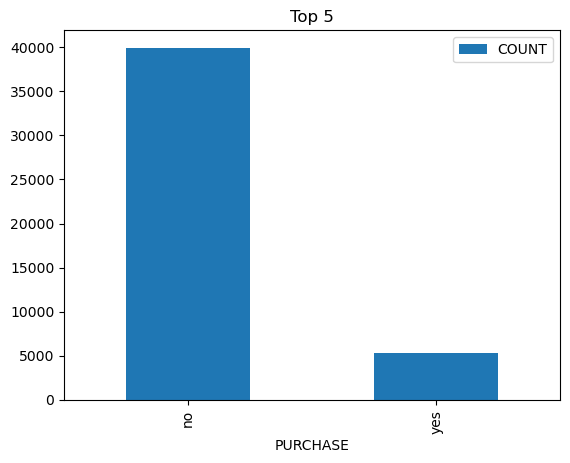

In [88]:
%matplotlib inline
df_col_frequency.plot.bar(x = 'PURCHASE', y = 'COUNT', title = 'Top ' + str(top_n));

Use a box plot to compare the buyers from the non-buyers based on the balance in their bank account.

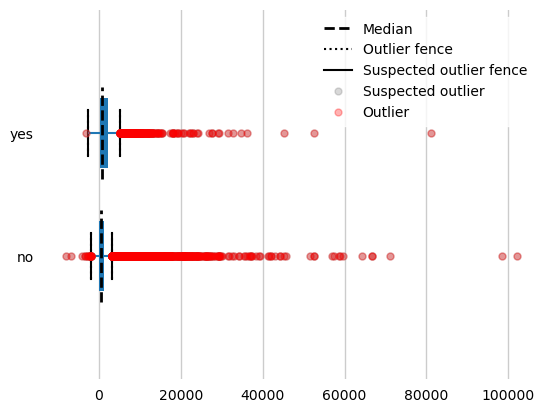

In [89]:
import matplotlib.pyplot as plt
from hana_ml.visualizers.eda import EDAVisualizer
f = plt.figure()
ax1 = f.add_subplot(111) # 111 refers to 1x1 grid, 1st subplot
eda = EDAVisualizer(ax1)
ax, cont = eda.box_plot(data = df_remote, column = 'BALANCE', groupby = 'PURCHASE', outliers = True)

That's a bit of a surprise. The contacts with the highest balances did not sign up for the term deposit. We are ready to train our
 Machine Learning model.
 # Train ML model
 Create a new Python 3 Notebook called “30 Train ML model”.
 Connect to SAP HANA Cloud.

In [90]:
import hana_ml.dataframe as dataframe
conn = dataframe.ConnectionContext(userkey = 'MYHANACLOUD')

Create a SAP HANA dataframe and point it to the table with the uploaded data. Sort the dataframe to ensure reproducibility.
 Alternatively, you can also base the SAP HANA dataframe on a SELECT statement as shown in the above "Data exploration" chapter.

In [91]:
df_remote = conn.table(table = 'BANKMARKETING', schema = 'ML_USER').sort('CUSTOMER_ID', desc = False)
df_remote.head(5).collect()

,CUSTOMER_ID,AGE,JOB,MARITAL,EDUCATION,DEFAULT,BALANCE,HOUSING,LOAN,CONTACT,DAY,MONTH,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME,PURCHASE
0,0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no


Create an object of type GradientBoostingBinaryClassifier, which will train the APL model.

In [92]:
from hana_ml.algorithms.apl.gradient_boosting_classification import GradientBoostingBinaryClassifier
gbapl_model = GradientBoostingBinaryClassifier()

Specify the target variable and the value the model should predict. By default the model will predict the occurrence of the less
 frequent value. Even though we want to predict the less common behaviour. it's prudent to be specific, which also helps document the
 model behaviour.

In [93]:
col_target = 'PURCHASE'
target_value = 'yes'

Specify the ID column.

In [94]:
col_id = 'CUSTOMER_ID'

Specify the predictor columns. Just remove the target and id columns.

In [95]:
col_predictors = df_remote.columns
col_predictors.remove(col_target)
col_predictors.remove(col_id)
col_predictors

['AGE',
 'JOB',
 'MARITAL',
 'EDUCATION',
 'DEFAULT',
 'BALANCE',
 'HOUSING',
 'LOAN',
 'CONTACT',
 'DAY',
 'MONTH',
 'CAMPAIGN',
 'PDAYS',
 'PREVIOUS',
 'POUTCOME']

Further configure how the model will be trained.

In [96]:
gbapl_model.set_params(eval_metric = 'AUC') # Metric used to evaluate the model performance
gbapl_model.set_params(cutting_strategy = 'random with no test') # Internal splitting strategy
gbapl_model.set_params(other_train_apl_aliases={'APL/VariableAutoSelection': 'true',
                                                'APL/Interactions': 'true',
                                                'APL/InteractionsMaxKept': 10,
                                                'APL/TargetKey': target_value})

Start the learning process. This might take a minute to calculate. The APL is now automatically going through the steps a Data
 Scientist would have to carry out manually. It is pre-processing the data, e.g. with binning, grouping or imputation, before
 calculating and testing different Gradient Boosting models.

In [97]:
gbapl_model.fit(data = df_remote,
                key = col_id,
                features = col_predictors,
                label = col_target)

When the model has been found, look at it's quality metric.

In [98]:
import pandas as pd
list_performance = gbapl_model.get_performance_metrics()
df_performance = pd.DataFrame(list(list_performance.items()), columns=['METRIC', 'VALUE'])
df_performance.loc[df_performance['METRIC'].isin(['AUC', 'BestIteration'])].style.hide(axis='index')

METRIC,VALUE
AUC,0.794800
BestIteration,124


We have an AUC of 0.82. The model was found in iteration number 276 in our case. A lot more information is available about the
 model. Looks at the basics, how many variables and records were used?

In [99]:
df_summary = gbapl_model.get_summary().filter("KEY in ('ModelVariableCount', 'ModelSelectedVariableCount', 'ModelRecordCount', 'ModelBuildDate')").collect()
df_summary = df_summary[['KEY','VALUE']]
df_summary['KEY'] = df_summary['KEY'].str.replace('Model', '').str.replace('Selected', 'Selected ')
df_summary['KEY'] = df_summary['KEY'].str.replace('Count', ' Count').str.replace('Date', ' Date')
df_summary.style.hide(axis='index')

KEY,VALUE
Variable Count,17
Selected Variable Count,15
Record Count,45211
Build Date,2023-07-31 15:51:24


All records from the dataset were used of course. You had provided 15 different variables for the model to consider. Plus the target
 variable \(PURCHASE\) and the ID \(CUSTOMER\_ID\) in total 17 variables were touched.
 Before looking deeper at the variables that were selected for the models, which ones have been excluded?

In [100]:
df_excluded = gbapl_model.get_indicators().filter("KEY like 'VariableExclusion%'").collect()
df_excluded = df_excluded[['VARIABLE','VALUE']]
df_excluded.columns = ['Excluded Variable', 'Reason']
df_excluded.style.hide(axis='index')

Excluded Variable,Reason
DEFAULT,Low contributory
JOB,Low contributory
PDAYS,Low contributory


Three predictor variables were dropped. But how important are the chosen / remaining variables for the model? The APL provides
 detailed information about the model that helps understand the model's behaviour. This is often called Global Explainable ML / AI. A
 Data Scientist might be interested to know, that the feature importance is based on Shapley.

In [101]:
list_contributions = gbapl_model.get_feature_importances()['ExactSHAP']
df_contribution = pd.DataFrame(list(list_contributions.items()), columns=['VARIABLE', 'CONTRIBUTION'])
df_contribution['CUMULATIVE'] = df_contribution['CONTRIBUTION'].cumsum()
format_dict = {'CONTRIBUTION':'{0:,.2%}','CUMULATIVE':'{0:,.2%}'}
df_contribution.style.format(format_dict).hide(axis='index')

VARIABLE,CONTRIBUTION,CUMULATIVE
CONTACT,21.50%,21.50%
MONTH,13.51%,35.02%
PREVIOUS,10.11%,45.12%
HOUSING,8.64%,53.76%
DAY,7.82%,61.58%
BALANCE,7.79%,69.37%
AGE,6.16%,75.53%
MARITAL,5.90%,81.43%
POUTCOME,5.81%,87.25%
CAMPAIGN,5.67%,92.91%


Most important is the CONTACT variable, followed by the MONTH in which the customer was contacted.
 A pareto plot helps see the importance of the variables. First ensure, that the seaborn package, which is used for the charting, is
 actually installed.

In [102]:
!pip install seaborn

Now the plot can be created.

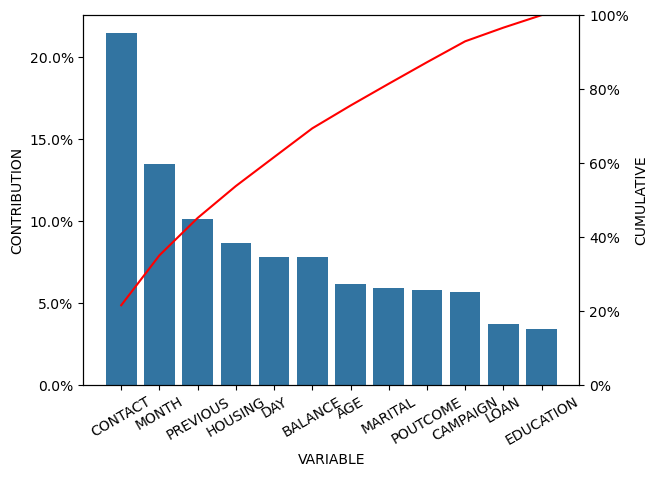

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
from  matplotlib.ticker import PercentFormatter
f = plt.figure()
ax1 = f.add_subplot(111) # 111 refers to 1x1 grid, 1st subplot
ax2 = ax1.twinx()
sns.barplot(data = df_contribution,
             x = 'VARIABLE',
             y = 'CONTRIBUTION',
             color = '#1f77b4',
             ax=ax1)
sns.lineplot(data = df_contribution, sort=False,
             x = 'VARIABLE',
             y = 'CUMULATIVE',
             color = 'red',
             ax=ax2)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=30)
ax1.yaxis.set_major_formatter(PercentFormatter(1))
ax2.yaxis.set_major_formatter(PercentFormatter(1))
ax2.set_ylim(0, 1)
plt.show();

So far we see which variables are most important to the model. You might be wondering though, what information is correlating with
 the behaviour you are looking for. During which months for example were the Marketing activities most successful. We can look into
 each variable and understand their behaviour in more detail.
 Obtain the detailed variable contribution for the MONTH.

In [104]:
variable_name = 'MONTH'
df_category_profit = gbapl_model.get_indicators().filter("KEY = 'GroupNormalProfit' and VARIABLE = '" + variable_name + "'").collect()
df_category_profit = df_category_profit[['VARIABLE', 'TARGET', 'DETAIL', 'VALUE']]
df_category_profit['VALUE'] = df_category_profit['VALUE'].astype(float)
df_category_profit.columns = ['Predictor', 'Target','Category','Profit']
df_category_profit = df_category_profit.sort_values(by = ['Profit'], ascending = False)
df_category_profit.style.format({'Profit':'{0:,.2%}'}).hide(axis='index')

Predictor,Target,Category,Profit
MONTH,PURCHASE,{dec;mar;oct;sep},36.65%
MONTH,PURCHASE,{apr},8.23%
MONTH,PURCHASE,{feb},5.63%
MONTH,PURCHASE,{aug;nov},-1.21%
MONTH,PURCHASE,{jan;jul;jun},-2.00%
MONTH,PURCHASE,{may},-4.98%


And bring these details into a plot.

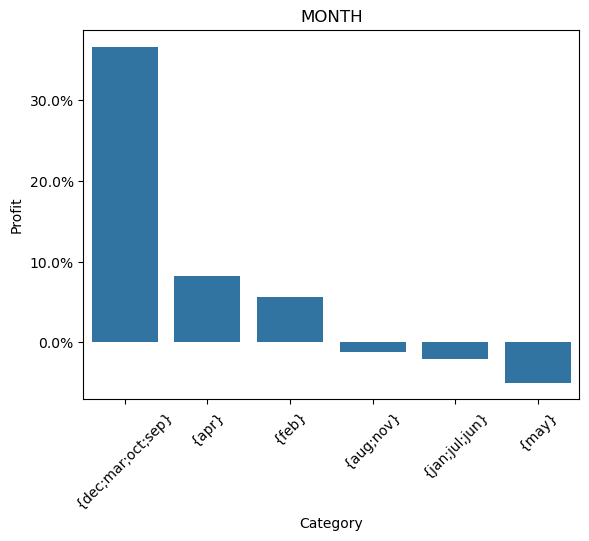

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
plt.figure()
bplot = sns.barplot(data = df_category_profit, x = 'Category', y = 'Profit', color = '#1f77b4')
bplot.set_title(variable_name)
bplot.set_xticklabels(bplot.get_xticklabels(), rotation = 45);
bplot.yaxis.set_major_formatter(PercentFormatter(1))

Categories on the left hand side in the above chart have the highest proportion of the target population. This means the purchasing
 affinity \(influence\) was highest when the customer was contacted in March, September, October or December.
 The categories are sorted in descending order of the proportion / influence. When the influence \(y-axis\) becomes negative, the
 target proportion of the category is lower than the overall's population. This means people were less likely to purchase. People
 were not keen to buy the product in May. In summary: the further left the category on the x-axis, the higher the affinity.
 Plot the category significance for some other variables. AGE is interesting for example. The relationship between age and purchasing
 affinity is not linear.
 For those who want to look a little deeper into the model, view the correlations between the input variables. The APL can calculate
 a full correlation matrix, as all input variables are encoded numerically. APL can deal with highly correlation variables, so you
 don't have to go this deep. However, in case there are highly correlated variables you can consider dropping these from the input
 variables to speed up the calculation time.

In [106]:
df_correlations = gbapl_model.get_indicators().filter("KEY = 'CorrelatedVariable'").collect()
df_correlations = df_correlations[['VARIABLE', 'DETAIL', 'VALUE']]
df_correlations['VALUE'] = df_correlations['VALUE'].astype(float).round(3)
df_correlations.columns = ['1st Variable', '2nd Variable', 'Coefficient']
df_correlations = df_correlations.sort_values(by = ['Coefficient'], ascending = False)
df_correlations.style.hide(axis='index')

1st Variable,2nd Variable,Coefficient
PDAYS,PREVIOUS,0.740000
PDAYS,POUTCOME,0.570000
PREVIOUS,POUTCOME,0.520000


There is nothing that would concern us here, but these three variables have fairly strong correlations to each other.
 Another optional deep-dive is a look at the interactions, which the model found between the variables.

In [107]:
df_interactions = gbapl_model.get_indicators().filter("KEY = 'InteractionValue' and to_char(VALUE) <> '0'").collect()
df_interactions = df_interactions[['VARIABLE', 'DETAIL', 'VALUE']]
df_interactions['VALUE'] = df_interactions['VALUE'].astype(float).round(3)
df_interactions.columns = ['1st Variable', '2nd Variable', 'Interaction']
df_interactions = df_interactions.sort_values(by = ['Interaction'], ascending = False)
df_interactions.style.format({'Interaction':'{0:,.3f}'}).hide(axis='index')

1st Variable,2nd Variable,Interaction
DAY,MONTH,0.095
MONTH,DAY,0.095
POUTCOME,PREVIOUS,0.095
PREVIOUS,POUTCOME,0.095
MONTH,CONTACT,0.080
CONTACT,MONTH,0.080
HOUSING,CONTACT,0.035
CONTACT,HOUSING,0.035
MONTH,POUTCOME,0.027
POUTCOME,MONTH,0.027


No strong interactions were found. We are just showing them here for you to know, that the APL's new
 GradientBoostingBinaryClassifier captures these automatically. These interactions can also be very relevant in interpreting the
 model's logic.
 Let's have a look at one further detail, that we can use later on. The model will be using SHAP scores for the predictions. With the
 complete trained model still available at the moment, we can find out the threshold score, which will be used to separate positive
 and negative predictions.

In [108]:
df_threshold = gbapl_model.get_indicators().filter("KEY = 'Threshold'").collect()
df_threshold = df_threshold[['VARIABLE', 'VALUE']]
df_threshold['VALUE'] = df_threshold['VALUE'].astype(float)
df_threshold.columns = ['Target', 'Score Treshold']
df_threshold.style.hide(axis='index')

Target,Score Treshold
PURCHASE,-1.199037


Scores below -1.15998 will lead to negative predictions. Scores above will lead to positive predictions.
 This score can be converted to the corresponding probability value:

In [109]:
import math
score = df_threshold.iloc[0, 1]
1 / (1 + math.exp(-score))

0.2316465597885017

We are now familiar with the model and could use it right away for predictions. However, it's also a good moment to save the model
 first to the SAP HANA Cloud.

In [110]:
from hana_ml.model_storage import ModelStorage
MODEL_SCHEMA = 'ML_USER' # HANA schema in which models are to be saved
model_storage = ModelStorage(connection_context=conn, schema = MODEL_SCHEMA)
gbapl_model.name = 'Bank Marketing Model'
model_storage.save_model(model=gbapl_model, if_exists = 'replace')

# Apply ML model
 Let's use the model to create predictions\! Create a new Python 3 Notebook called “40 Apply ML model”.
 Connect to SAP HANA Cloud.

In [111]:
import hana_ml.dataframe as dataframe
conn = dataframe.ConnectionContext(userkey = 'MYHANACLOUD')

Create the SAP HANA DataFrame, which points to the table with the entities that need to be predicted. Sort the data for
 reproducibility.

In [112]:
df_remote_new = conn.table(table = 'BANKMARKETING_TOPREDICT', schema = 'ML_USER').sort("CUSTOMER_ID", desc = False)
df_remote_new.head(5).collect()

,CUSTOMER_ID,AGE,JOB,MARITAL,EDUCATION,DEFAULT,BALANCE,HOUSING,LOAN,CONTACT,DAY,MONTH,CAMPAIGN,PDAYS,PREVIOUS,POUTCOME
0,1,40,entrepreneur,married,secondary,no,3000,yes,no,unknown,10,may,1,-1,0,unknown
1,2,65,management,single,tertiary,no,3000,no,no,telephone,10,mar,1,-1,12,success


Load the trained ML model.

In [113]:
from hana_ml.model_storage import ModelStorage
MODEL_SCHEMA = 'ML_USER' # HANA schema from where models are to be loaded
model_storage = ModelStorage(connection_context = conn, schema = MODEL_SCHEMA)
gbapl_model = model_storage.load_model(name = 'Bank Marketing Model', version = 1)

Apply the model to predict the behaviour of the two customers. For each person we obtain an overall probability of purchasing the
 product \(proba\_PURCHASE\) and the yes / no prediction.

In [114]:
gbapl_model.set_params(extra_applyout_settings =
                        {'APL/ApplyExtraMode': 'Advanced Apply Settings',
                         'APL/ApplyDecision': 'true',
                         'APL/ApplyProbability': 'true',
                         'APL/ApplyPredictedValue': 'false'
                        })
df_remote_predict = gbapl_model.predict(df_remote_new)
df_predict = df_remote_predict.head(10).collect()
df_predict.columns = [hdr.replace('gb_', '') for hdr in df_predict.columns] # shorten column names
df_predict.style.format({'proba_PURCHASE':'{0:,.3f}'}).hide(axis='index')

CUSTOMER_ID,PREDICTED,proba_PURCHASE
1,no,0.033
2,yes,0.796


If you would like to understand which characteristics of a customer contributed towards a positive or negative prediction, you can
 leverage the so called SHAP values.

In [115]:
gbapl_model.set_params(extra_applyout_settings={'APL/ApplyExtraMode': 'Individual Contributions'})
df_remote_predict = gbapl_model.predict(df_remote_new)
df_predict = df_remote_predict.head(10).collect()
df_predict.columns = [hdr.replace("gb_", "") for hdr in df_predict.columns] # Shorten column names
df_predict

,CUSTOMER_ID,PREDICTED,score_PURCHASE,contrib_AGE,contrib_MARITAL,contrib_EDUCATION,contrib_BALANCE,contrib_HOUSING,contrib_LOAN,contrib_CONTACT,contrib_DAY,contrib_MONTH,contrib_CAMPAIGN,contrib_PREVIOUS,contrib_POUTCOME,contrib_constant_bias
0,1,no,-3.362570,-0.061166,-0.101978,-0.042685,0.249151,-0.116452,0.028893,-0.950099,0.000683,-0.260125,0.084510,-0.197137,0.053647,-2.049811
1,2,yes,1.361992,0.580599,0.058357,0.110169,0.255366,0.183404,0.044148,-0.099252,0.013740,0.792756,0.104633,0.430414,0.937468,-2.049811


Each prediction relates to a SHAP value \(score\_PURCHASE\), which itself is a sum of the SHAP values of the individual predictors,
 which are also shown. The higher the overall score, the higher the probability the person will purchase the product. Earlier on we
 saw the threshold that is used to differentiate between positive and negative predictions \(1.15998 in this case\).
 If you want to better understand how the variables contributed to these individual predictions \(local explainable ML / AI, just
 rearrange the data format and visualise them in a plot.

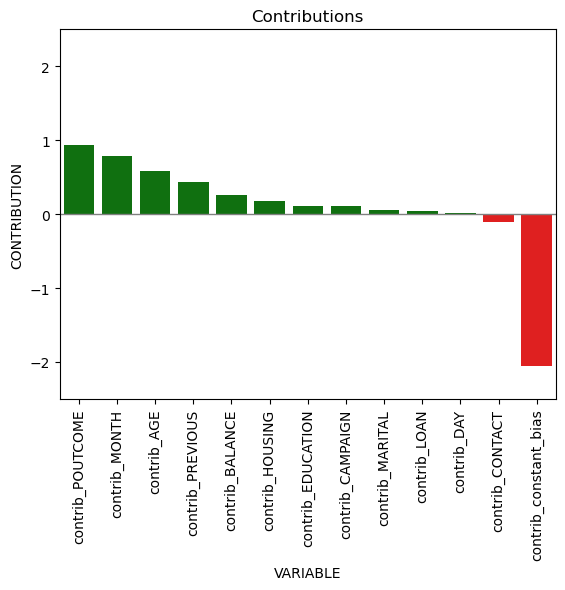

In [116]:
df_contributions_single = df_predict[df_predict['CUSTOMER_ID'] == 2]
df_contributions_single = df_contributions_single.melt(id_vars = ['CUSTOMER_ID', 'PREDICTED', 'score_PURCHASE'])
df_contributions_single.columns = ['CUSTOMER_ID', 'PREDICTED', 'SCORE', 'VARIABLE', 'CONTRIBUTION']
df_contributions_single = df_contributions_single.sort_values(by = ['CONTRIBUTION'], ascending = [False])
df_contributions_single.style.format({'CONTRIBUTION':'{0:,.3f}'})
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.figure()
bar_color = np.where(df_contributions_single['CONTRIBUTION'] > 0 ,'green', 'red')
bplot = sns.barplot(data = df_contributions_single, x = 'VARIABLE', y = 'CONTRIBUTION',  palette = bar_color.tolist())
bplot.set_title('Contributions')
bplot.set_xticklabels(bplot.get_xticklabels(), rotation = 90)
plt.axhline(y = 0, color = 'grey', linewidth = 1)
plt.ylim(-2.5, 2.5);

The above plot shows the variable's contribution for customer number 2. Towards the left the variables that contributed most
 strongly to a positive prediction are shown. The "contrib\_constant\_bias" shown in the plot is not a variable. It is an element of
 the trained model, which can be interpreted as an average, which is adjusted by the individual variables.
 Write the predictions to a table in SAP HANA Cloud, where other processes or Analytical tools like SAP Analytics Cloud can pick them
 up.

In [117]:
df_remote_predict.save(where=('ML_USER', 'BANKMARKETING_PREDICTED'),
                       table_type = 'COLUMN',
                       force = True)

Just close the connection, and you are done.

In [118]:
conn.close()

# Deployment
 SAP Data Intelligence provides the platform to deploy HANA ML models into production. Its "ML Scenario Manager" for example combines
 Jupyter Notebooks for creation with graphical pipelines for deployment.
 You can deploy both the Automated Predictive Library \(APL\) and the Predictive Algorithm Library \(PAL\) as well as open source
 like Python or R.
 It is important that your HANA ML operators use a recent version of the Python library hana\_ml \(version 2.5.x\). This is already
 the case with SAP Data Intelligence Cloud.
 # Summary
 Well done for making it to the end of this tutorial\! You have connected to SAP HANA Cloud, uploaded and explored data, before
 training a Machine Learning model, whose logic you explored. Until eventually you applied the model to create predictions, whose
 drivers you also looked at.
 Hopefully you had fun along the way and want to work with this further\! You can continue with the next hands-on tutorial, in which
 you score your APL model in stand-alone JavaScript. Independent of SAP HANA, this provides deployment flexibility. You could use the
 model in an IoT scenario, directly at the edge. Or wherever JavaScript can run.
 Here are some further links you might find useful.
   - SAP HANA Python Client API for Machine Learning Algorithms
   - Documentation SAP HANA Automated Predictive Library
   - Sample Notebooks for the Automated Predictive Library
   - Updates for the Data Scientist, building SAP HANA embedded Machine Learning scenarios from Python or R
 Marc Daniau and Andreas Forster
 Follow __Like __RSS Feed